build a encoder-decoder model order input from least to greastest.  first step just return the indices of fixed lenght input, second step variable lenght input, embedding layer and pointer network. 

Note that sequences are of fixed length

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

/Users/bm255022/virtualenvs/tensorflow27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Global config variables
num_steps = 4 
batch_size = 16
state_size = 12
learning_rate = 0.1


In [3]:

def gen_data(time_steps, batch_size, num_batches):
    X = np.random.rand(num_batches * batch_size, time_steps)
    Y = np.asarray([np.argsort(e) for e in X])
    for i in range(num_batches):
        _x = X[i * batch_size:(i + 1) * batch_size]
        _y = Y[i * batch_size:(i + 1) * batch_size]
        yield _x, _y


In [4]:
x = tf.placeholder(tf.float32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')


#add a dimension so matrix multiplication works later on.  we really want [batch, steps, features]
rnn_inputs = tf.expand_dims(x, 2)
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
rnn_inputs = tf.unstack(rnn_inputs, axis=1)


In [5]:
def rnn_cell(rnn_input, state, W, b):
     return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [6]:
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [1 + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

init_state = tf.zeros([batch_size, state_size])
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state, W, b)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [7]:
#decoder inputs

# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
decoder_inputs = tf.expand_dims(y, 2)
decoder_inputs = tf.unstack(decoder_inputs, axis=1)

#we want to insert starter symbols at beginning of list and drop last element of list
start = tf.ones([batch_size, 1])
start = tf.scalar_mul(-1, start)
decoder_inputs.insert(0, start)
del decoder_inputs[-1]


In [8]:


#decoder cell
with tf.variable_scope('decoder_cell'):
    W = tf.get_variable('W', [1 + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

state = final_state #start with state from encoder rnn

decoder_outputs = []
for decoder_input in decoder_inputs:
    decoder_input = tf.cast(decoder_input, dtype=tf.float32)
    state = rnn_cell(decoder_input, state, W, b)
    decoder_outputs.append(state)

In [9]:
num_classes = num_steps
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(decoder_output, W) + b for decoder_output in decoder_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]
predictions = tf.stack(predictions, axis=1)
predictions

<tf.Tensor 'stack:0' shape=(16, 4, 4) dtype=float32>

In [10]:
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [11]:

def train_network(num_epochs, num_steps, state_size, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for i in range(num_epochs):
            training_loss = 0

            if verbose:
                print("\nEPOCH", i)
            d = gen_data(time_steps=4, batch_size=16, num_batches=4000)
            for j in range(4000):
                X,Y = d.next()
                training_state = np.zeros((batch_size, state_size))
                tr_losses, training_loss_, training_state, _, preds_ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step,
                              predictions],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_

                if j % 40 == 0 and j > 0:
                    if verbose:
                        print("Average loss at step", j,
                              "for last 250 steps:", training_loss / 100)
                    training_losses.append(training_loss / 100)
                    training_loss = 0
                   
        #now how does it work?
        test = gen_data(time_steps=4, batch_size=16, num_batches=40)
        for j in range(40):
            X,Y = test.next()
            preds = sess.run([predictions], feed_dict={x:X, y:Y})
 
       
    return training_losses



('\nEPOCH', 0)
('Average loss at step', 40, 'for last 250 steps:', 0.5105258929729461)
('Average loss at step', 80, 'for last 250 steps:', 0.37278902649879453)
('Average loss at step', 120, 'for last 250 steps:', 0.2980762231349945)
('Average loss at step', 160, 'for last 250 steps:', 0.24952352821826934)
('Average loss at step', 200, 'for last 250 steps:', 0.22264297515153886)
('Average loss at step', 240, 'for last 250 steps:', 0.2031621977686882)
('Average loss at step', 280, 'for last 250 steps:', 0.17671496003866197)
('Average loss at step', 320, 'for last 250 steps:', 0.16929384738206862)
('Average loss at step', 360, 'for last 250 steps:', 0.15837768465280533)
('Average loss at step', 400, 'for last 250 steps:', 0.1446136212348938)
('Average loss at step', 440, 'for last 250 steps:', 0.14580245882272722)
('Average loss at step', 480, 'for last 250 steps:', 0.1385104975104332)
('Average loss at step', 520, 'for last 250 steps:', 0.1259600581228733)
('Average loss at step', 560, '

('Average loss at step', 520, 'for last 250 steps:', 0.05625895939767361)
('Average loss at step', 560, 'for last 250 steps:', 0.05294831223785877)
('Average loss at step', 600, 'for last 250 steps:', 0.058236170113086703)
('Average loss at step', 640, 'for last 250 steps:', 0.05909490011632443)
('Average loss at step', 680, 'for last 250 steps:', 0.05514598920941353)
('Average loss at step', 720, 'for last 250 steps:', 0.06043466594070196)
('Average loss at step', 760, 'for last 250 steps:', 0.05758766457438469)
('Average loss at step', 800, 'for last 250 steps:', 0.05533305801451206)
('Average loss at step', 840, 'for last 250 steps:', 0.05237128980457783)
('Average loss at step', 880, 'for last 250 steps:', 0.05695154555141926)
('Average loss at step', 920, 'for last 250 steps:', 0.05896990150213242)
('Average loss at step', 960, 'for last 250 steps:', 0.052125022634863856)
('Average loss at step', 1000, 'for last 250 steps:', 0.05621853467077017)
('Average loss at step', 1040, 'for

('Average loss at step', 1080, 'for last 250 steps:', 0.04367982801049948)
('Average loss at step', 1120, 'for last 250 steps:', 0.04406185545027256)
('Average loss at step', 1160, 'for last 250 steps:', 0.05125971540808678)
('Average loss at step', 1200, 'for last 250 steps:', 0.04414914611726999)
('Average loss at step', 1240, 'for last 250 steps:', 0.04266453340649605)
('Average loss at step', 1280, 'for last 250 steps:', 0.048433497175574304)
('Average loss at step', 1320, 'for last 250 steps:', 0.05081631436944008)
('Average loss at step', 1360, 'for last 250 steps:', 0.05071753144264221)
('Average loss at step', 1400, 'for last 250 steps:', 0.04553279478102922)
('Average loss at step', 1440, 'for last 250 steps:', 0.048411111272871496)
('Average loss at step', 1480, 'for last 250 steps:', 0.04423455905169248)
('Average loss at step', 1520, 'for last 250 steps:', 0.04473547592759133)
('Average loss at step', 1560, 'for last 250 steps:', 0.04507839221507311)
('Average loss at step'

('Average loss at step', 1680, 'for last 250 steps:', 0.03704017035663128)
('Average loss at step', 1720, 'for last 250 steps:', 0.04252249963581562)
('Average loss at step', 1760, 'for last 250 steps:', 0.04285022936761379)
('Average loss at step', 1800, 'for last 250 steps:', 0.040112005807459356)
('Average loss at step', 1840, 'for last 250 steps:', 0.03850931029766798)
('Average loss at step', 1880, 'for last 250 steps:', 0.04635607235133648)
('Average loss at step', 1920, 'for last 250 steps:', 0.04169235836714506)
('Average loss at step', 1960, 'for last 250 steps:', 0.044597432017326355)
('Average loss at step', 2000, 'for last 250 steps:', 0.04062433302402496)
('Average loss at step', 2040, 'for last 250 steps:', 0.04037464164197445)
('Average loss at step', 2080, 'for last 250 steps:', 0.04019703686237335)
('Average loss at step', 2120, 'for last 250 steps:', 0.044541550911962983)
('Average loss at step', 2160, 'for last 250 steps:', 0.038704958111047745)
('Average loss at ste

('Average loss at step', 2160, 'for last 250 steps:', 0.04704861644655466)
('Average loss at step', 2200, 'for last 250 steps:', 0.03838025100529194)
('Average loss at step', 2240, 'for last 250 steps:', 0.038232678398489955)
('Average loss at step', 2280, 'for last 250 steps:', 0.036331555861979725)
('Average loss at step', 2320, 'for last 250 steps:', 0.038204447738826273)
('Average loss at step', 2360, 'for last 250 steps:', 0.04092755977064371)
('Average loss at step', 2400, 'for last 250 steps:', 0.03778654582798481)
('Average loss at step', 2440, 'for last 250 steps:', 0.039048873111605646)
('Average loss at step', 2480, 'for last 250 steps:', 0.032561152540147305)
('Average loss at step', 2520, 'for last 250 steps:', 0.03849044941365719)
('Average loss at step', 2560, 'for last 250 steps:', 0.034861895404756066)
('Average loss at step', 2600, 'for last 250 steps:', 0.0359333061799407)
('Average loss at step', 2640, 'for last 250 steps:', 0.03973127268254757)
('Average loss at st

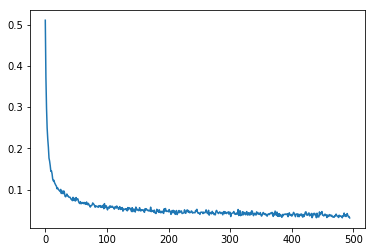

In [12]:

training_losses = train_network(5,num_steps, state_size)
plt.plot(training_losses)